In [1]:
!pip install transformers

In [23]:
from transformers import TFAlbertModel, AlbertConfig, AlbertTokenizerFast, TFAutoModelForSequenceClassification
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
reviews_df = pd.read_csv('amazon_reviews.csv', index_col=0)
reviews_df.head(5)

,rating,text
0,5,\n I tested the AA size Amazon brand battery ...
1,1,\n I've been buying AA and AAA batteries from...
2,1,\n Don't buy these. I did save a bunch of $'...
3,1,\n I loved these batteries when I first star...
4,1,\n I read a lot of reviews and convinced myse...


<AxesSubplot:xlabel='rating', ylabel='count'>

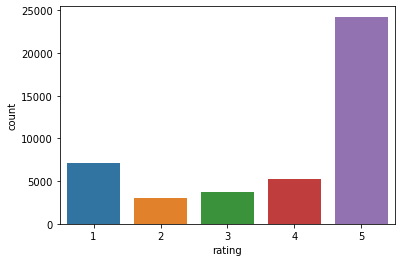

In [3]:
sns.countplot(x='rating', data=reviews_df)

In [5]:
#rows_to_drop = np.random.choice(reviews_df[reviews_df['rating'] == 5].index, 17000, False)
rows_to_drop1 = np.random.choice(reviews_df[reviews_df['rating'] == 5].index, 20000, False)
rows_to_drop2 = np.random.choice(reviews_df[reviews_df['rating'] == 1].index, 3000, False)
rows_to_drop3 = np.random.choice(reviews_df[reviews_df['rating'] == 4].index, 1500, False)

rows_to_drop = np.concatenate([rows_to_drop1, rows_to_drop2, rows_to_drop3])
reviews_df.drop(rows_to_drop, axis=0, inplace=True)

<AxesSubplot:xlabel='rating', ylabel='count'>

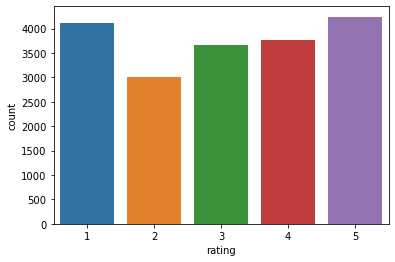

In [5]:
sns.countplot(x='rating', data=reviews_df)

In [20]:
data = np.asarray(reviews_df)

y = to_categorical(data[:, 0].astype('int32'))
y = y[:, 1:]

x = data[:, 1]
print('X shape = ' + str(x.shape))

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]
X shape = (18813,)


In [71]:
model_name = 'albert-base-v1'
max_length = 250

config = AlbertConfig.from_pretrained(model_name)
config.output_hidden_states = False
config.hidden_dropout_prob = 0.15

tokenizer = AlbertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)
transformer_model = TFAlbertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at albert-base-v1 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [72]:
albert = transformer_model.layers[0]

inputs = Input(shape=(max_length,), name='input_ids', dtype='int32')

albert_model = albert(inputs)[1]
pooled_output = Dropout(config.hidden_dropout_prob, name='pooled_output')(albert_model, training=False)

output = Dense(5, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=config.initializer_range))(pooled_output)

model = Model(inputs=inputs, outputs=output)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 250)]             0         
_________________________________________________________________
albert (TFAlbertMainLayer)   TFBaseModelOutputWithPool 11683584  
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 3845      
Total params: 11,687,429
Trainable params: 11,687,429
Non-trainable params: 0
_________________________________________________________________


In [73]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(5e-05), loss=tf.keras.losses.CategoricalCrossentropy(from_logits = True), metrics=
             ['accuracy'])

In [74]:
X_tok = tokenizer(
    text=x.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

In [75]:
h = model.fit(X_tok['input_ids'], y, epochs=15, batch_size=16, validation_split=0.2)

Epoch 1/15
941/941 [==============================] - 290s 297ms/step - loss: 1.6168 - accuracy: 0.2221 - val_loss: 1.4607 - val_accuracy: 0.3702

Text(0.5, 1.0, 'Accuracy')

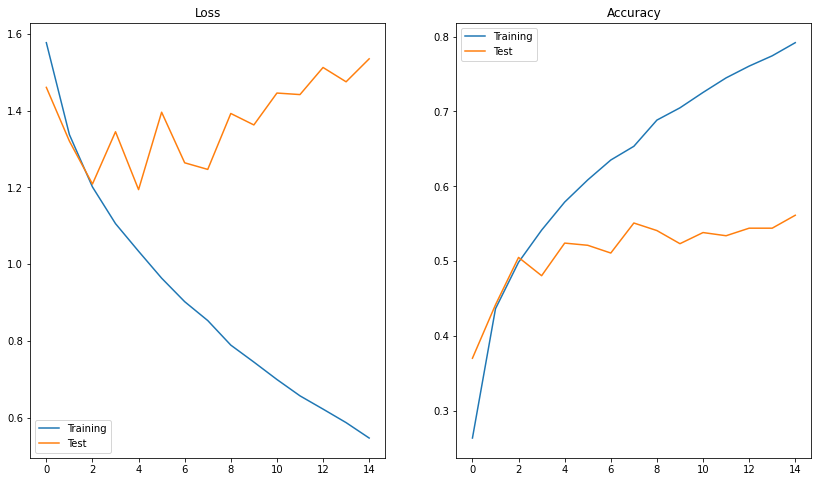

In [76]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 8))

ax[0].plot(h.history['loss'], label='Training')
ax[0].plot(h.history['val_loss'], label='Test')
ax[0].legend()
ax[0].set_title('Loss')

ax[1].plot(h.history['accuracy'], label='Training')
ax[1].plot(h.history['val_accuracy'], label='Test')
ax[1].legend()
ax[1].set_title('Accuracy')

In [77]:
fig.savefig('transformer.png')

In [ ]:
!sudo shutdown -h now